# Boosted Trees

Vamos a analizar el funcionamiento de los métodos de Gradient Boosting de sklearn mediante ejemplos ilustrativos. 

## Contenidos

1. Un problema de clasificación
2. Un problema de regresión

## Librerías y funciones

Lo primero es cargar las librerías y funciones necesarias.

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
%matplotlib inline

cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

import warnings
warnings.filterwarnings('ignore')

# 1. Un problema de clasificación

Utilizaremos el [Pima Indian Diabetes dataset](https://www.kaggle.com/uciml/pima-indians-diabetes-database).

<div class = "alert alert-success">
EJERCICIO: Cargue los datos almacenados en el fichero *diabetes.csv*
</div>

### Cargamos datos

In [2]:
# tu código aquí
data = pd.read_csv("./data/diabetes.csv") # cargamos fichero
data.shape

(768, 9)

In [3]:
data.head()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


In [4]:
data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


In [5]:
data.dtypes

Pregnancies                   int64
Glucose                       int64
BloodPressure                 int64
SkinThickness                 int64
Insulin                       int64
BMI                         float64
DiabetesPedigreeFunction    float64
Age                           int64
Outcome                       int64
dtype: object

In [6]:
data['Outcome'].value_counts()

0    500
1    268
Name: Outcome, dtype: int64

### Análisis exploratorio básico

<div class = "alert alert-success">
EJERCICIO: Represente el histograma de cada variable separando por clases, ¿hay alguna característica que convenga transformar?
Nota: Si lo considera de utilidad, reutilice el código del Notebook anterior.
</div>

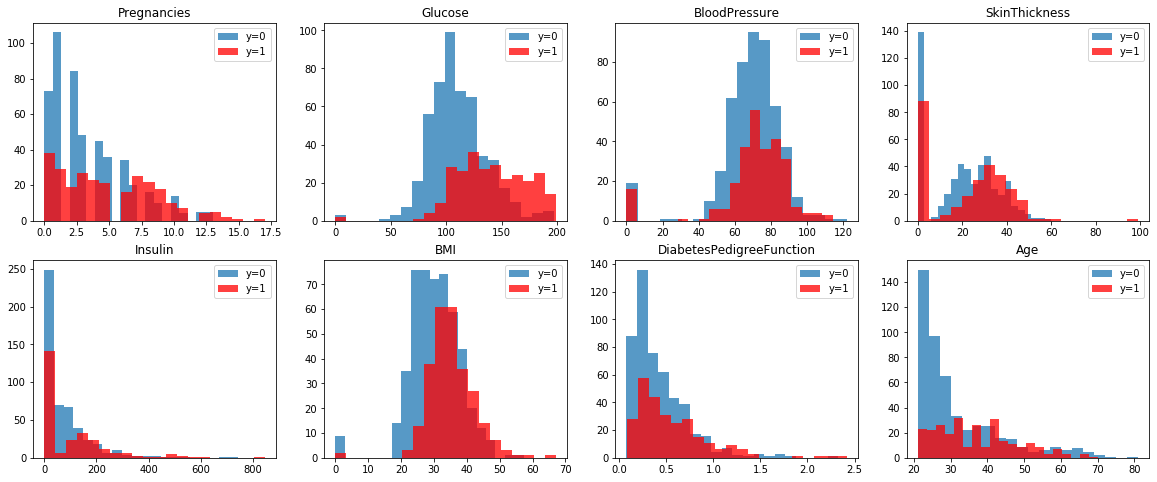

In [8]:
# Pintamos histogramas para cada clase
plt.figure(figsize=(20,8))

idx_0 =  data['Outcome'] == 0
idx_1 =  data['Outcome'] == 1

for i,feature in enumerate(data.columns.drop(['Outcome'])):
    plt.subplot(2,4,i+1)   
    plt.hist(data.loc[idx_0,feature],density=0, bins=20, alpha=0.75,label='y=0')
    plt.hist(data.loc[idx_1,feature],density=0, bins=20, facecolor='red', alpha=0.75,label='y=1')
    plt.legend()
    plt.title(feature)

plt.show()

<div class = "alert alert-success">
EJERCICIO: A la vista de los histogramas anteriores, ¿cómo de separable crees que es el problema?
</div>

Construyamos nuestro conjunto de test

In [9]:
from sklearn.model_selection import train_test_split

# preparamos los datos
features = data.columns.drop(['Outcome'])
X = data[features].values
y = data['Outcome'].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=0, stratify=y)

print('Datos train: ', X_train.shape)
print('Datos test:  ', X_test.shape)

Datos train:  (614, 8)
Datos test:   (154, 8)


In [10]:
print(np.unique(y_train, return_counts=True))
print(np.unique(y_test, return_counts=True))

(array([0, 1], dtype=int64), array([400, 214], dtype=int64))
(array([0, 1], dtype=int64), array([100,  54], dtype=int64))


In [12]:
214/X_train.shape[0]

0.3485342019543974

### Decision trees

Probemos primero con un árbol de decisión sencillo

<div class = "alert alert-success">
EJERCICIO: Entrena un árbol de decisión sencillo, y muestra las prestaciones para el conjunto de test.
</div>

best mean cross-validation score: 0.736
best parameters: {'max_depth': 2}


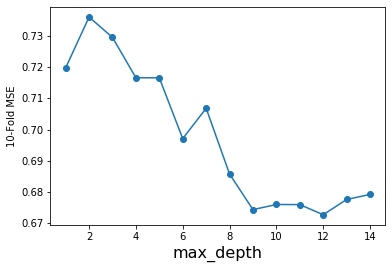

In [13]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree


maxDepth = range(1,15)
param_grid = {'max_depth': maxDepth }
grid = GridSearchCV(DecisionTreeClassifier(random_state=0), param_grid=param_grid, cv = 3)
grid.fit(X_train, y_train)
print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

scores = np.array(grid.cv_results_['mean_test_score'])
plt.plot(maxDepth,scores,'-o')
plt.xlabel('max_depth',fontsize=16)
plt.ylabel('10-Fold MSE')
#plt.ylim((-1, 0))
plt.show()

Pintemos el árbol, a ver qué variables no salen más relevantes:

<div class = "alert alert-success">
EJERCICIO: Representa el árbol entrenado
</div>

In [14]:
maxDepthOptimo = grid.best_params_['max_depth']
treeModel = DecisionTreeClassifier(max_depth=maxDepthOptimo).fit(X_train,y_train)

print("Train: ",treeModel.score(X_train,y_train))
print("Test: ",treeModel.score(X_test,y_test))

Train:  0.7638436482084691
Test:  0.8051948051948052


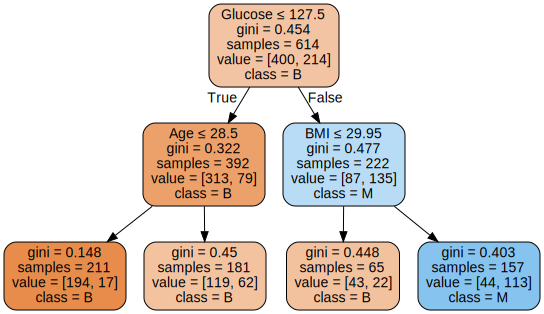

In [15]:
from sklearn.tree import export_graphviz
import graphviz

# tu código aquí
tree_dot = export_graphviz(treeModel, out_file=None, feature_names=features, class_names=['B','M'],  
                         filled=True, rounded=True,  special_characters=True)
graph = graphviz.Source(tree_dot) 
graph

Parece un problema complicado de clasificar, porque la profundidad del árbol óptima es 2. El algoritmo está bien entrenado porque la diferencia entre train y test es pequeña. Si queremos mejorar prestaciones tendremos que acudir a un modelo más complejo.

### Boosted Trees

El entrenamiento del algoritmo de boosting requiere fijar tres parámetros libres:

- Número de iteraciones
- Tasa de aprendizaje ($\alpha$)
- Complejidad del árbol: *max_depth*

Se podría hacer una búsqueda sobre los tres parámetros conjuntamente mediante GridSearchCV, sin embargo, es muy costoso computacionalmente, con lo que es más sencillo aplicar una optimización secuencial: se prueban distintos valores de los parámetros libres, se fijan los óptimos y se busca sobre el resto (sin embargo, esta aproximación no garantiza la combinación óptima)

In [16]:
from sklearn.ensemble import GradientBoostingClassifier

Niterations = [25,50,75,100,125,150,175,200,300]
learningRate = [0.5,0.1,0.05,0.01]
# mantenemos max_depth estático: max_depth=2

param_grid = {'n_estimators': Niterations,'learning_rate':learningRate }
grid = GridSearchCV(GradientBoostingClassifier(random_state=0, max_depth=2), param_grid=param_grid, cv = 5)
grid.fit(X_train, y_train)
print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

best mean cross-validation score: 0.761
best parameters: {'learning_rate': 0.01, 'n_estimators': 200}


Representemos el error que estamos cometiendo para los distintos valores de los parámetros libres

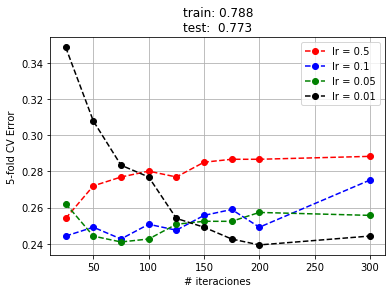

In [17]:
lrOptimo = grid.best_params_['learning_rate']
neOptimo = grid.best_params_['n_estimators']
# calculamos métricas globales
bt = GradientBoostingClassifier(random_state=0, max_depth=2,learning_rate=lrOptimo, n_estimators=neOptimo)
bt.fit(X_train,y_train)

error = 1-grid.cv_results_['mean_test_score'].reshape(len(learningRate),len(Niterations))
colors = ['r','b','g','k','m']
for i,lr in enumerate(learningRate):    
    plt.plot(Niterations,error[i,:],colors[i] + '--o',label='lr = %g'%lr)

plt.legend()
plt.xlabel('# iteraciones')
plt.ylabel('5-fold CV Error')
plt.title('train: %0.3f\ntest:  %0.3f'%(bt.score(X_train,y_train),bt.score(X_test,y_test)))
plt.grid()
plt.show()

Las prestaciones no son mucho mejores que con respecto a un árbol sencillo. Como el coste de entrenamiento de este conjunto no es muy grande, replicaremos el análisis anterior aumentando el valor de la complejidad.

In [18]:
Niterations = [25,50,75,100,125,150,175,200,300]
learningRate = [0.5,0.1,0.05,0.01]
# mantenemos max_depth estático: max_depth=3

param_grid = {'n_estimators': Niterations,'learning_rate':learningRate }
grid = GridSearchCV(GradientBoostingClassifier(random_state=0, max_depth=3), param_grid=param_grid, cv = 5)
grid.fit(X_train, y_train)
print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

best mean cross-validation score: 0.757
best parameters: {'learning_rate': 0.05, 'n_estimators': 100}


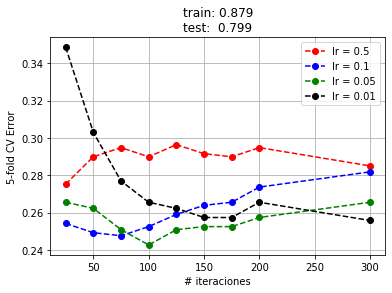

In [19]:
# calculamos métricas globales
lrOptimo = grid.best_params_['learning_rate']
neOptimo = grid.best_params_['n_estimators']
bt = GradientBoostingClassifier(random_state=0, max_depth=3,learning_rate=lrOptimo, n_estimators=neOptimo)
bt.fit(X_train,y_train)

error = 1-grid.cv_results_['mean_test_score'].reshape(len(learningRate),len(Niterations))
colors = ['r','b','g','k','m']
for i,lr in enumerate(learningRate):    
    plt.plot(Niterations,error[i,:],colors[i] + '--o',label='lr = %g'%lr)

plt.legend()
plt.xlabel('# iteraciones')
plt.ylabel('5-fold CV Error')
plt.title('train: %0.3f\ntest:  %0.3f'%(bt.score(X_train,y_train),bt.score(X_test,y_test)))
plt.grid()
plt.show()

Vemos que al aumentar la complejidad, necesitamos una tasa de aprendizaje más pequeña. En general, cuanto más complejo es el problema, menor es la tasa de aprendizaje y mayor el número de iteraciones que necesita el algoritmo. Parece que podemos ir un poco más allá, disminuyamos un poco más la tasa de aprendizaje

In [20]:
Niterations = [25,50,75,100,125,150,175,200,300,500]
learningRate = [0.5,0.1,0.05,0.01,0.005]
# mantenemos max_depth estático: max_depth=3

param_grid = {'n_estimators': Niterations,'learning_rate':learningRate }
grid = GridSearchCV(GradientBoostingClassifier(random_state=0, max_depth=3), param_grid=param_grid, cv = 5)
grid.fit(X_train, y_train)
print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

best mean cross-validation score: 0.757
best parameters: {'learning_rate': 0.05, 'n_estimators': 100}


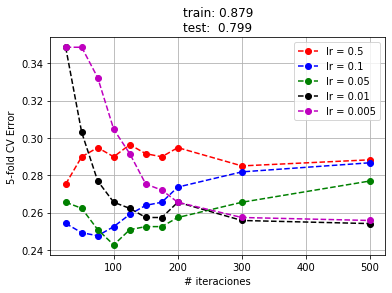

In [21]:
# calculamos métricas globales
lrOptimo = grid.best_params_['learning_rate']
neOptimo = grid.best_params_['n_estimators']
bt = GradientBoostingClassifier(random_state=0, max_depth=3,learning_rate=lrOptimo, n_estimators=neOptimo)
bt.fit(X_train,y_train)

error = 1-grid.cv_results_['mean_test_score'].reshape(len(learningRate),len(Niterations))
colors = ['r','b','g','k','m']
for i,lr in enumerate(learningRate):    
    plt.plot(Niterations,error[i,:],colors[i] + '--o',label='lr = %g'%lr)

plt.legend()
plt.xlabel('# iteraciones')
plt.ylabel('5-fold CV Error')
plt.title('train: %0.3f\ntest:  %0.3f'%(bt.score(X_train,y_train),bt.score(X_test,y_test)))
plt.grid()
plt.show()

# ojo con hacer barridos sobre muchas características, que luego no pueden sacarse gráficas!
# aquí un ejemplo sobre dos dimensiones: https://stackoverflow.com/a/43645640
# y aquí uno sobre tres: https://stackoverflow.com/a/55766938/4346986

Podemos representar también la importancia de las variables

<div class = "alert alert-success">
EJERCICIO: Representa la importancia de las variables
</div>

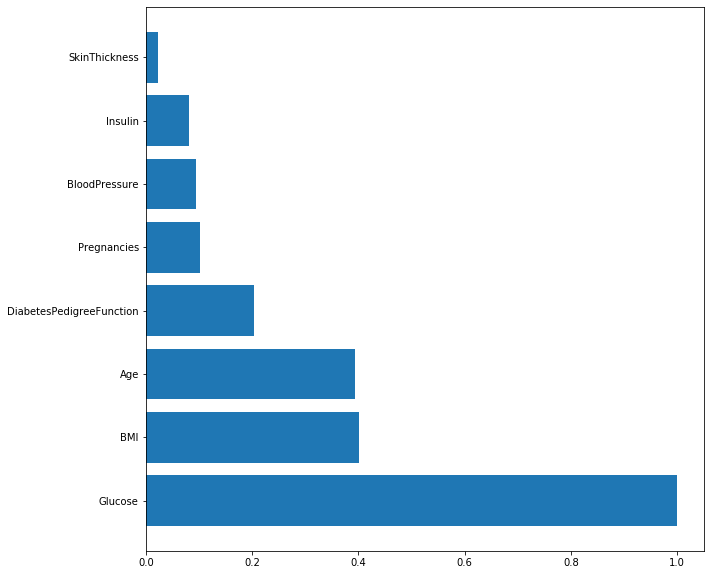

In [22]:
# tu código aquí
importances = bt.feature_importances_
importances = importances / np.max(importances)

indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10,10))
plt.barh(range(X_train.shape[1]),importances[indices])
plt.yticks(range(X_train.shape[1]),features[indices])
plt.show()

Y también podemos representar la dependencia de cada característica con la variable target

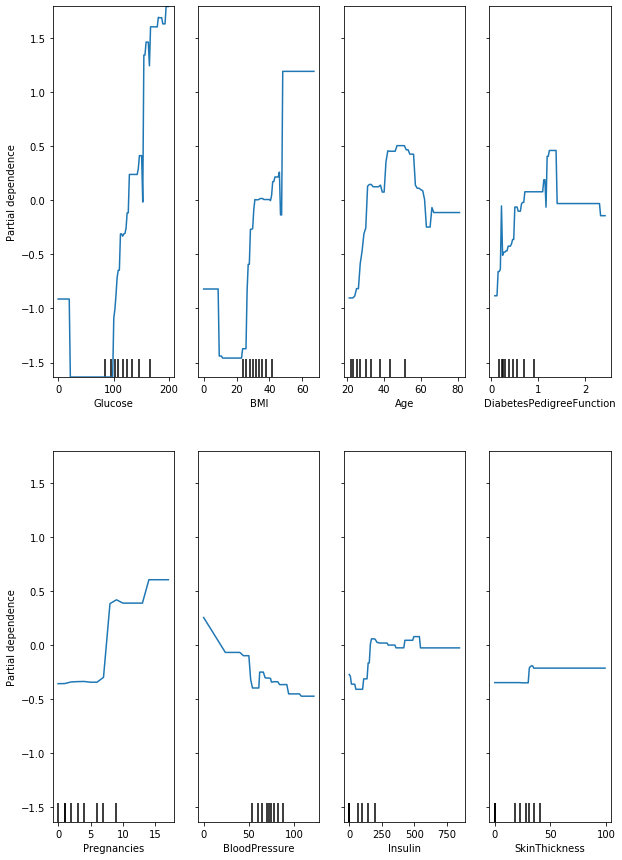

In [23]:
from sklearn.inspection import plot_partial_dependence

importances = bt.feature_importances_
importances = importances / np.max(importances)
indices = np.argsort(importances)[::-1]

plot_partial_dependence(bt, X_train, indices, feature_names=features, percentiles=(0.0, 1.0), n_cols = 4)
fig = plt.gcf()
fig.set_size_inches(10,15)
plt.show()

# 2. Un problema de regresión

Volvemos a nuestro conjunto de datos ya conocido:

In [24]:
# cargamos datos
house_data = pd.read_csv("./data/kc_house_data.csv") # cargamos fichero

# Eliminamos las columnas id y date 
house_data = house_data.drop(['id','date'], axis=1)

# convertir las variables en pies al cuadrado en metros al cuadrado 
feetFeatures = ['sqft_living','sqft_lot','sqft_above','sqft_basement','sqft_living15','sqft_lot15']
house_data[feetFeatures] = house_data[feetFeatures].apply(lambda x: x * 0.3048 * 0.3048)

# renombramos
house_data.columns = ['price','bedrooms','bathrooms','sqm_living','sqm_lot','floors','waterfront','view','condition',
                      'grade','sqm_above','sqm_basement','yr_built','yr_renovated','zip_code','lat','long',
                      'sqm_living15','sqm_lot15']

# añadimos las nuevas variables
house_data['years']            = 2017 - house_data['yr_built']
house_data['bedrooms_squared'] = house_data['bedrooms'].apply(lambda x: x**2)
house_data['bed_bath_rooms']   = house_data['bedrooms']*house_data['bathrooms']
house_data['log_sqm_living']   = house_data['sqm_living'].apply(lambda x: np.log(x))
house_data['lat_plus_long']    = house_data['lat']*house_data['long']

# convertimos el DataFrame al formato necesario para scikit-learn
data = house_data.values

y = data[:,0:1]     # nos quedamos con la 1ª columna, price
X = data[:,1:]      # nos quedamos con el resto

feature_names = house_data.columns[1:]

# Dividimos los datos en entrenamiento y test (80 training, 20 test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.25, random_state = 2)

print('Datos entrenamiento: ', X_train.shape)
print('Datos test: ', X_test.shape)

Datos entrenamiento:  (16209, 23)
Datos test:  (5404, 23)


Dado que el número de muestras del problema es mayor, y para no extender el entrenamiento, escogeremos de forma muy secuencial los parámetros libres.

AVISO: Este proceso va a tardar un rato ...

In [25]:
from sklearn.ensemble import GradientBoostingRegressor

Niterations = [1500,2000, 2500]
learningRate = [0.1,0.05]
# mantenemos max_depth estático: max_depth=3

param_grid = {'n_estimators': Niterations,'learning_rate':learningRate }
grid = GridSearchCV(GradientBoostingRegressor(random_state=0, max_depth=3), param_grid=param_grid, cv = 5)
grid.fit(X_train, y_train)
print("best mean cross-validation score: {:.3f}".format(grid.best_score_))
print("best parameters: {}".format(grid.best_params_))

best mean cross-validation score: 0.887
best parameters: {'learning_rate': 0.05, 'n_estimators': 2500}


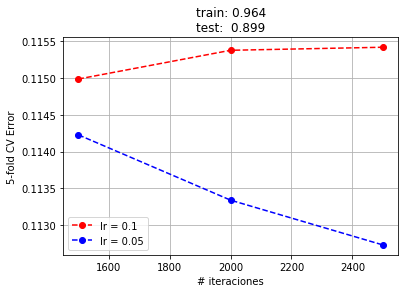

In [26]:
lrOptimo = grid.best_params_['learning_rate']
neOptimo = grid.best_params_['n_estimators']
bt = GradientBoostingRegressor(random_state=0, max_depth=3,learning_rate=lrOptimo, n_estimators=neOptimo)
bt.fit(X_train,y_train)

error = 1-grid.cv_results_['mean_test_score'].reshape(len(learningRate),len(Niterations))
colors = ['r','b','g','k','m']
for i,lr in enumerate(learningRate):    
    plt.plot(Niterations,error[i,:],colors[i] + '--o',label='lr = %g'%lr)

plt.legend()
plt.xlabel('# iteraciones')
plt.ylabel('5-fold CV Error')
plt.title('train: %0.3f\ntest:  %0.3f'%(bt.score(X_train,y_train),bt.score(X_test,y_test)))
plt.grid()
plt.show()

### Importancia y dependencia

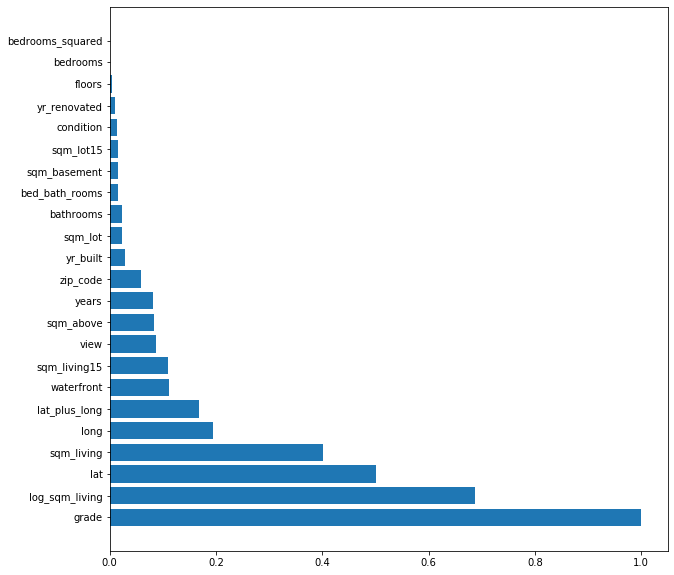

In [27]:
importances = bt.feature_importances_
importances = importances / np.max(importances)

indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10,10))
plt.barh(range(X_train.shape[1]),importances[indices])
plt.yticks(range(X_train.shape[1]),feature_names[indices])
plt.show()

Por último, representemos los conocidos como *partial dependence plots*:

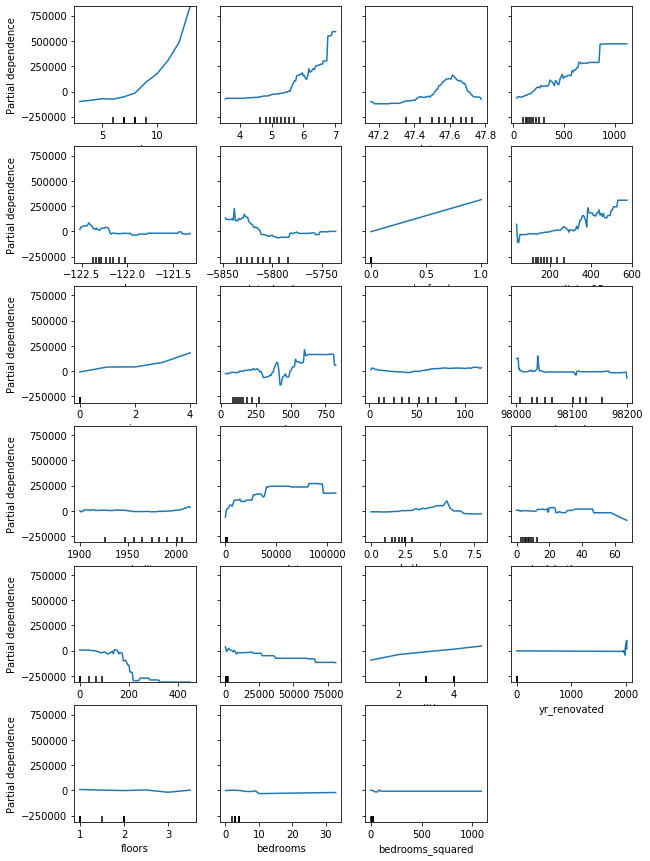

In [29]:
from sklearn.inspection import plot_partial_dependence

importances = bt.feature_importances_
importances = importances / np.max(importances)
indices = np.argsort(importances)[::-1]

plot_partial_dependence(bt, X_train, indices, feature_names=feature_names, percentiles=(0.0, 1.0), n_cols = 4)
fig = plt.gcf()
fig.set_size_inches(10,15)
plt.show()

### What's next?

Así que, ¿qué más podríamos hacer? aumentar *max_depth*, pero seguramente incurramos en overfitting. Aquí radica el arte del *machine learning*:

1. Conoce el problema (negocio), para generar nuevas *features* de interés
2. Trata de buscar más instancias para utilizar técnicas de aprendizaje profundo (o reducir el overfitting)